In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
import pymc3

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
TITLE_FONT_SIZE = 14
AXIS_FONT_SIZE = 12

import seaborn as sns
palette = sns.light_palette("navy")

In [3]:
W = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0]
])

D = np.diag(np.sum(W, axis=0))

In [4]:
def alr(theta):
    return np.log(theta[:-1] / theta[-1])

def inv_alr(x):
    theta = np.concatenate([np.exp(x), np.array([1.0])])
    return theta / np.sum(theta)

In [5]:
def sample_cov(x, y):
    n = x.size
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / (n - 1)  

## $\tilde w_i \sim N(0, (D - \rho W)^{-1}_{ii} \Sigma)$

In [25]:
def simulate_one_marginal(A, Sigma, i, nsamples):
    dim = Sigma.shape[0]
    draws = np.random.multivariate_normal(mean=np.zeros(dim), cov=A[i, i] * Sigma, size=nsamples)
    return np.apply_along_axis(inv_alr, 1, draws)

In [26]:
def simulate_indep(Sigma, nsamples):
    dim = Sigma.shape[0]
    draws = np.random.multivariate_normal(mean=np.zeros(dim), cov=Sigma, size=nsamples)
    return np.apply_along_axis(inv_alr, 1, draws)

In [27]:
rho = 0.9
A = np.linalg.inv(D - rho * W)

In [12]:
corr = -0.9
var = 1
Sigma = np.array([[var, corr], [corr, var]])
draws = simulate_one_marginal(A, Sigma, 1, 10000)

In [89]:
i = 1
var = 1
covs01 = []
covs02 = []
covs12 = []
corrs = np.linspace(-0.99, 0.99, 20)

for corr in corrs:
    Sigma = np.array([[var, corr], [corr, var]])
    #draws = simulate_one_marginal(A, Sigma, i, 10000)
    draws = simulate_indep(Sigma, 10000)
    covs01.append(sample_cov(draws[:, 0], draws[:, 1]))
    covs02.append(sample_cov(draws[:, 0], draws[:, 2]))
    covs12.append(sample_cov(draws[:, 1], draws[:, 2]))

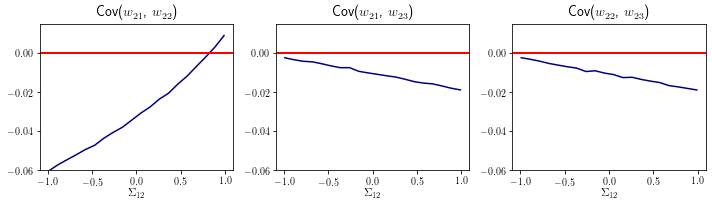

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(corrs, covs01, color=palette[-1])
axes[0].set_title(r"Cov($w_{{{%i}}1}$, $w_{{{%i}}2}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[0].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

axes[1].plot(corrs, covs02, color=palette[-1])
axes[1].set_title(r"Cov($w_{{{%i}}1}$, $w_{{{%i}}3}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[1].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

axes[2].plot(corrs, covs12, color=palette[-1])
axes[2].set_title(r"Cov($w_{{{%i}}2}$, $w_{{{%i}}3}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[2].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

for i in range(3):
    axes[i].axhline(0, color="red", lw=2)
    axes[i].set_ylim((-0.06, 0.015))
plt.tight_layout()
plt.savefig("../images/cov_w1.pdf")
plt.show()

## $(\tilde w_i, w \theta_j)  \sim N(0, (D - \rho W)^{-1}_{(i,j) \times (i, j)}  \otimes \Sigma)$

In [16]:
# This function simulates from the joint marginal distribution
# of (theta_{i}, theta_{j})

def simulate_joint_marginal(A, Sigma, i, j, nsamples):
    dim = Sigma.shape[0]
    cov = np.kron(A[[[i],[j]],[i, j]], Sigma)
    draws = np.random.multivariate_normal(mean=np.zeros(2 * dim), cov=cov, size=nsamples)
    theta_i = np.apply_along_axis(inv_alr, 1, draws[:, :dim])
    theta_j = np.apply_along_axis(inv_alr, 1, draws[:, dim:])
    return theta_i, theta_j

In [54]:
np.logspace(0.6, 0.9, 5) / 8

array([0.49763396, 0.59143907, 0.70292666, 0.8354299 , 0.99291029])

In [55]:
i = 0
j = 2

rhos = [0.5, 0.75, 0.925, 0.9725, 0.99]
corrs = np.linspace(-0.99, 0.99, 20)
covs_by_rho = []

for rho in rhos:
    A = np.linalg.inv(D - rho * W)
    covs = defaultdict(list)
    for corr in corrs:
        Sigma = np.array([[var, corr], [corr, var]])
        ws = simulate_joint_marginal(A, Sigma, i, j, 10000)
        for l in range(3):
            for m in range(3):
                covs[(l, m)].append(sample_cov(ws[0][:, l], ws[1][:, m]))
    covs_by_rho.append(covs)

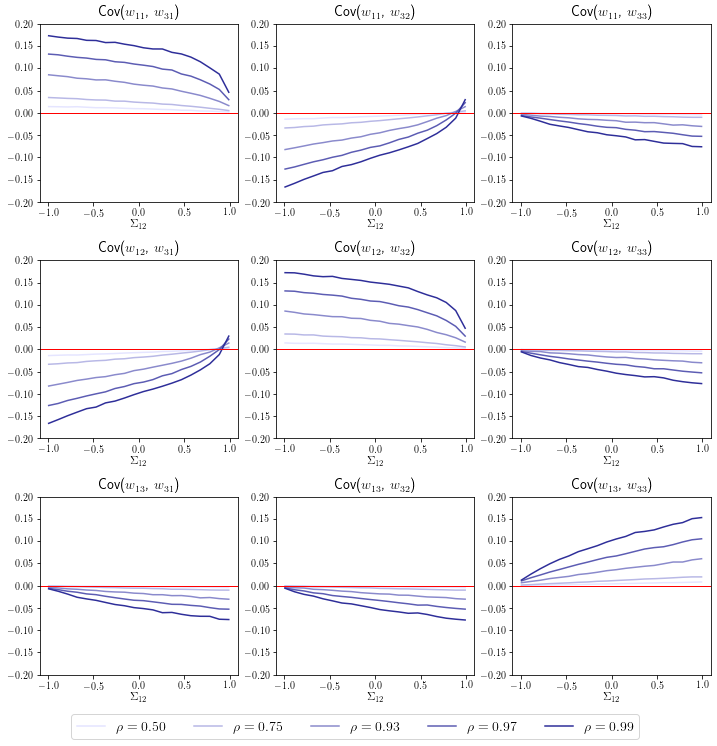

In [88]:
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for l in range(3):
    for m in range(3):
        for k, rho in enumerate(rhos):
            covs = covs_by_rho[k]
            axes[l][m].plot(corrs, covs[(l, m)], color=palette[k], label=r"$\rho = {{%.2f}}$" % (rho))
            axes[l][m].set_title(r"Cov($w_{{{%i}} {{%i}}}$, $w_{{{%i}} {{%i}}}$)" % (i+1, l+1, j+1, m+1),
                              fontsize=TITLE_FONT_SIZE)
            axes[l][m].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)
            axes[l][m].set_ylim(-0.2, 0.2)
            axes[l][m].axhline(0, color="red", lw=1)

plt.tight_layout()
axes[2][1].legend(loc="lower center", bbox_to_anchor=(0.4, -0.4), ncol=5, fontsize=AXIS_FONT_SIZE+2)

plt.savefig("../images/cov_w1_w3.pdf")
plt.show()

## Simulation against independent Dirichlet

In [8]:
from scipy.stats import dirichlet
import matplotlib.lines
import matplotlib.tri as tri

In [9]:
Nsamples = 20
samplesDir1 = dirichlet.rvs([1, 1, 1], Nsamples)
samplesDir2 = dirichlet.rvs([1, 1, 1], Nsamples)

In [10]:
corr = 0.5
var = 1.0
Sigma = np.array([[var, corr], [corr, var]])
samplesLogit1, samplesLogit2 = simulate_joint_marginal(A, Sigma, 0, 1, Nsamples)

NameError: name 'simulate_joint_marginal' is not defined

In [11]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

In [12]:
SQRT3 = np.sqrt(3)
SQRT3OVER2 = SQRT3 / 2.

def unzip(l):
    return zip(*l)

def permute_point(p, permutation=None):
    if not permutation:
        return p
    return [p[int(permutation[i])] for i in range(len(p))]

def project_point(p, permutation=None):
    permuted = permute_point(p, permutation=permutation)
    a = permuted[0]
    b = permuted[1]
    x = a + b/2.
    y = SQRT3OVER2 * b
    return np.array([x, y])

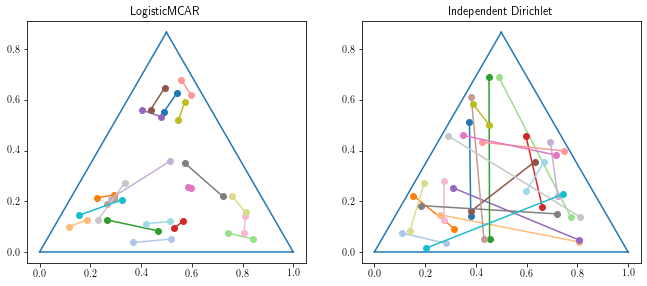

In [23]:
cmap = matplotlib.cm.get_cmap("tab20")

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

axes[0].triplot(triangle)
axes[1].triplot(triangle)

for i in range(Nsamples):
    proj1 = project_point(samplesLogit1[i, :])
    proj2 = project_point(samplesLogit2[i, :])
    
    axes[0].plot([proj1[0]], [proj1[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[0].plot([proj2[0]], [proj2[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[0].plot([proj1[0], proj2[0]], [proj1[1], proj2[1]], "-", color=cmap.colors[i])
    
axes[0].set_title("LogisticMCAR")
axes[0].set_aspect("equal")
    
for i in range(Nsamples):
    proj1 = project_point(samplesDir1[i, :])
    proj2 = project_point(samplesDir2[i, :])
    
    axes[1].plot([proj1[0]], [proj1[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[1].plot([proj2[0]], [proj2[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[1].plot([proj1[0], proj2[0]], [proj1[1], proj2[1]], "-", color=cmap.colors[i])
    
axes[1].set_title("Independent Dirichlet")
axes[1].set_aspect("equal")

# plt.savefig("../images/triplot.pdf")
plt.show()

## Histogram of distancies

In [24]:
Nsamples = 10000
samplesDir1 = dirichlet.rvs([1, 1, 1], Nsamples)
samplesDir2 = dirichlet.rvs([1, 1, 1], Nsamples)

distDir = np.sqrt(np.sum((samplesDir1 - samplesDir2) ** 2, axis=1))

In [25]:
corr = 0.5
Sigma = np.array([[var, corr], [corr, var]])
distLogits = []

samplesLogit1, samplesLogit2 = simulate_joint_marginal(A, Sigma, 0, 1, Nsamples)
distLogits.append(np.sqrt(np.sum((samplesLogit1 - samplesLogit2) ** 2, axis=1)))

samplesLogit1, samplesLogit2 = simulate_joint_marginal(A, Sigma, 0, 4, Nsamples)
distLogits.append(np.sqrt(np.sum((samplesLogit1 - samplesLogit2) ** 2, axis=1)))

In [38]:
np.where(distLogits == max(distLogits[1]))

(array([1]), array([7414]))

In [27]:
xlim = max(max(list(map(max, distLogits))), max(distDir))

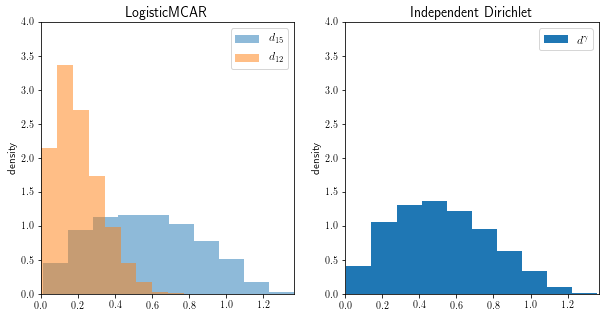

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].hist(distLogits[1], alpha=0.5, label=r"$d_{15}$", density=True)
axes[0].hist(distLogits[0], alpha=0.5, label=r"$d_{12}$", density=True)
axes[0].set_title("LogisticMCAR", fontsize=TITLE_FONT_SIZE)

axes[1].hist(distDir, density=True, label=r"$d^\gamma$")
axes[1].set_title("Independent Dirichlet", fontsize=TITLE_FONT_SIZE)
for i in range(2):
    axes[i].set_xlim((0, xlim))
    axes[i].set_ylim(0, 4)
    axes[i].set_ylabel("density", fontsize=TITLE_FONT_SIZE-3)
    

axes[0].legend(loc="upper right", fontsize=TITLE_FONT_SIZE-2)
axes[1].legend(loc="upper right", fontsize=TITLE_FONT_SIZE-2)
# plt.savefig("../images/distances_hist.pdf")
plt.show()

In [30]:
import pandas as pd

df = pd.DataFrame({"d12": distLogits[0], "d15": distLogits[1], "dgamma": distDir})
df.to_csv("../data/simulation_distances.csv")

## Sparse Mixtures

In [372]:
def simulate_logit_normal(Sigma, nsamples):
    dim = Sigma.shape[0]
    mean = np.random.normal(loc=0, scale=40, size=dim)
    draws = np.random.multivariate_normal(mean=mean, cov=Sigma, size=nsamples)
    return np.apply_along_axis(inv_alr, 1, draws)

In [373]:
var = 5
cov = 0

dim = 10
Nsamples = 10000
Sigma = np.ones((dim -1, dim-1)) * cov
for i in range(dim - 1):
    Sigma[i, i] = var
samplesLogit1 = simulate_logit_normal(Sigma, Nsamples)

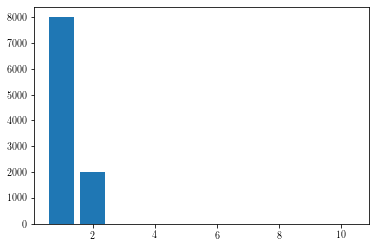

In [374]:
num_nonzero = np.zeros(Nsamples)
for i in range(Nsamples):
    num_nonzero[i] = len(np.where(samplesLogit1[i, :] > 0.01)[0])
    
x = np.arange(1, 11)
y = np.array([np.sum(num_nonzero == i) for i in x])
plt.bar(x, y)
plt.show()

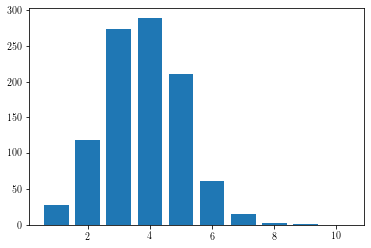

In [152]:
samplesdir = dirichlet.rvs(np.ones(10) / 10, Nsamples)
num_nonzero = np.zeros(Nsamples)

for i in range(Nsamples):
    num_nonzero[i] = len(np.where(samplesdir[i, :] > 0.01)[0])

x = np.arange(1, 11)
y = np.array([np.sum(num_nonzero == i) for i in x])

plt.bar(x, y)
plt.show()

In [92]:
samplesLogit1[0, :]

array([0.05124482, 0.14642973, 0.06307856, 0.04526436, 0.07705617,
       0.1049109 , 0.13989763, 0.13544183, 0.07030195, 0.16637404])

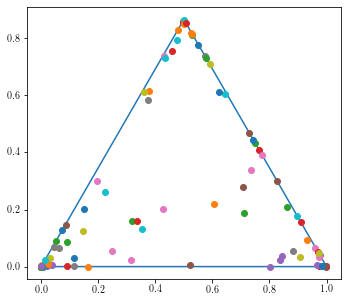

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(11, 5))

axes.triplot(triangle)

for i in range(Nsamples):
    proj1 = project_point(samplesLogit1[i, :])

    axes.plot([proj1[0]], [proj1[1]], marker="o", figure=fig)

axes.set_aspect("equal")
plt.show()

## Contour Plots

In [27]:
from scipy.stats import kde

In [66]:
def simulate_with_mean(nsamples):
    dim = 3
    out = np.zeros((nsamples, 2))
    for i in range(nsamples):
        mean = np.random.normal(loc=0, scale=3, size=dim-1)
        draw = np.random.multivariate_normal(mean=mean, cov=np.eye(dim-1))
        out[i, :] = draw
    return np.apply_along_axis(inv_alr, 1, out)

def ylinspace(x):
    if x < 0.5:
        return np.linspace(0, np.sqrt(3) / 2 * x, 50)
    else:
        return np.linspace(0, np.sqrt(3) / 2 * (x - 1) , 50)

In [67]:
samples = simulate_with_mean(1000)
projected = np.apply_along_axis(project_point, 1, samples)
x, y = projected.T

In [68]:
nbins = 50
k = kde.gaussian_kde(projected.T)

# generate grid on triangle
xx = np.linspace(0, 1, 50)
points = []
for xp in xx:
    ygrid = ylinspace(xp)
    for yp in ygrid:
        points.append([xp, yp])

xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

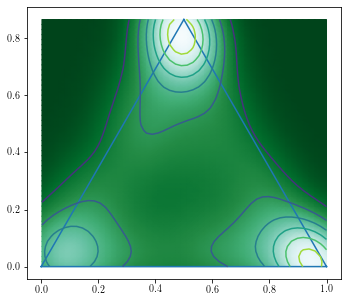

In [69]:
fig, axes = plt.subplots(1, 1, figsize=(11, 5))
axes.triplot(triangle)

axes.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes.contour(xi, yi, zi.reshape(xi.shape))

axes.set_aspect("equal")
plt.show()

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(11, 5))
axes.triplot(triangle)


for i in range(samples.shape[0]):
    proj1 = project_point(samples[i, :])
    axes.plot([proj1[0]], [proj1[1]], marker="o", figure=fig)

axes.set_aspect("equal")
plt.show()

array([0.55513352, 0.76866309])